In [1]:
%run support.py
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.image as mpimg
import matplotlib.patches as patches
import h5py, time, datetime, json
import scipy.integrate as integrate
from scipy.optimize import curve_fit, brentq
from lmfit import minimize, Parameters, report_fit
plt.style.use('~/Shared JupyterHub Notebooks/interactive.mplstyle')

R_wire=4200 * 2/Rk
timeformat = mdates.DateFormatter('%H:%M')
datediff = mdates.datestr2num('1970-01-01')-mdates.datestr2num('1904-01-01')
print(f"Datediff between fucking Apple and UNIX TIME STAMP {datediff*24*3600} seconds")
datafolder = "/mnt/Measurement_Data/phys-dots-26/Cooldown38"
gT = 0.29525
Ec = 1.51986/2

Datediff between fucking Apple and UNIX TIME STAMP 2082844800.0 seconds


# Precool

In [2]:
# Load mixing chamber data
time_started = datetime.datetime.strptime("2019/12/19 12:20:43", '%Y/%m/%d %H:%M:%S').timestamp()
time_completed = datetime.datetime.strptime("2020/01/05 14:41:23", '%Y/%m/%d %H:%M:%S').timestamp()

result = GetBFData(6, time_started, time_completed)

#result = GetBFData(6, "2019-12-19 12:20:43", "2020-01-05 14:41:23")

result[:,0] = result[:,0] - result[0,0]
result[:,1] = MakeSmoothie(result[:,1], ws=50)
time_MC = result[:,0]
temp_MC = result[:,1]
# Load CBT temperature during precooling
precoolwaves = [806, 812, 813, 814, 815, 816, 817, 818]
time_cbt_precool = np.zeros(0)
temp_cbt_precool = np.zeros(0)
for i, wn in enumerate(precoolwaves):
    filename = f"d{wn}_time.h5"
    with h5py.File(f"{datafolder}/{filename}", 'r') as f:
        t = np.array(f['x_array'])
        g = np.array(f['GcbtlowEc'])
        b = np.array(f['bzIPSB'])
    flt = np.logical_not(np.isnan(g))
    t = t[flt]
    g = g[flt]
    b = [flt]
    if i==0:
        t0 = t[0]
    g = 1/(1/g - 2*R_wire)
    Temp = Tcbt_Cu(g/gT, Ec=Ec*1e3)
    time_cbt_precool = np.append(time_cbt_precool, (t-t0))
    temp_cbt_precool = np.append(temp_cbt_precool, Temp)
    
temp_cbt_precool = MakeSmoothie(temp_cbt_precool, ws=500)/1000
Tcbt0_precool = np.average(temp_cbt_precool[0:10])

# Demag

In [3]:
# Load CBT temperature during demag
demagwaves = [819]
time_cbt_demag = np.zeros(0)
temp_cbt_demag = np.zeros(0)
b_demag = np.zeros(0)
for i, wn in enumerate(demagwaves):
    filename = f"d{wn}_time.h5"
    print(f"Filename = {filename}")
    with h5py.File(f"{datafolder}/{filename}", 'r') as f:
        t = np.array(f['x_array'])
        g = np.array(f['GcbtlowEc'])
        b = np.array(f['bzIPSB'])
    flt = np.logical_not(np.isnan(g))
    t = t[flt]
    g = g[flt]
    b = b[flt]
    g = 1/(1/g - 2*R_wire)
    temp = Tcbt_Cu(g/gT, Ec=Ec*1e3)
    time_cbt_demag = np.append(time_cbt_demag, t)
    temp_cbt_demag = np.append(temp_cbt_demag, temp)
    b_demag = np.append(b_demag, b)

last_index = np.min(np.where(b_demag<=0.06))
time_cbt_demag = time_cbt_demag[0:last_index]
temp_cbt_demag = temp_cbt_demag[0:last_index]/1000
b_demag = b_demag[0:last_index]
t_f_demag = time_cbt_demag[-1]
T0_demag = [np.average(temp_cbt_demag[0:10]), np.average(temp_cbt_demag[0:10]), np.average(temp_MC[-10:-1])]
print("Initial temperatures: ", T0_demag)

# Demag
def Tdot_demag(t, T, A, p, QdotparBefore, QdotplBefore, QdotparAfter, QdotplAfter):
    Te, Tn, Tepl, Tnpl = T
    local_h = np.interp([t-1,t,t+1], time_cbt_demag, b_demag)
    h = local_h[1]
    hdot = (local_h[2] - local_h[0])/2
    
    Qdotpar_local = QdotparBefore if h>2 else QdotparAfter
    Qdotpl_local = QdotplBefore if h>2 else QdotplAfter
    
    Qdot = Qdotpar_local - A*(Te**p - Tepl**p)/nmol # Heat from outside of CBT
    C_n = Cn(Tn,h)
    C_e = Ce(Te)
    Cpl_n = Cn(Tnpl,h)
    Cpl_e = Ce(Tepl)
    
    Tedot = Qdotpar_local/C_e - (Te - Tn)*(Tn*C_n/(Korringa*C_e))
    Tndot = Tn*(Te-Tn)/Korringa + Tn*hdot/h
    Tepldot = Qdotpl_local/Cpl_e - (Tepl - Tnpl)*(Tnpl*Cpl_n/(Korringa*Cpl_e))
    Tnpldot = Tnpl*(Tepl-Tnpl)/Korringa + Tnpl*hdot/h
    return [Tedot, Tndot, Tepldot, Tnpldot]

Filename = d819_time.h5
Initial temperatures:  [15.927065067951839, 15.927065067951839, 0.012155860000000001]


# Warm-up

In [4]:
warmupwaves = [819, 823, 824]
time_cbt_warmup = np.zeros(0)
temp_cbt_warmup = np.zeros(0)
b_warmup = np.zeros(0)
for i, wn in enumerate(warmupwaves):
    filename = f"d{wn}_time.h5"
    with h5py.File(f"{datafolder}/{filename}", 'r') as f:
        t = np.array(f['x_array'])
        g = np.array(f['GcbtlowEc'])
        b = np.array(f['bzIPSB'])
    flt = np.logical_not(np.isnan(g))
    bflt = b<0.0601
    t = t[bflt]
    g = g[bflt]
    b = b[bflt]
    g = 1/(1/g - 2*R_wire)
    temp = Tcbt_Cu(g/gT, Ec=Ec*1e3)/1000
    time_cbt_warmup = np.append(time_cbt_warmup, t)
    temp_cbt_warmup = np.append(temp_cbt_warmup, temp)
    b_warmup = np.append(b_warmup, b)
Bf = b_warmup[-1]

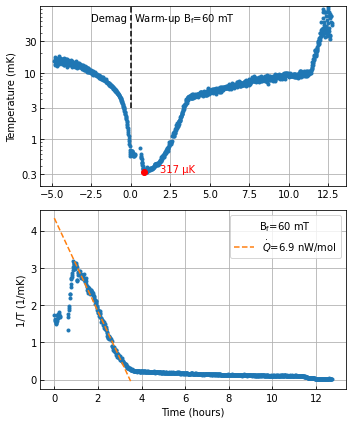

In [5]:
fig, ax = plt.subplots(2,1,figsize=(5, 6))

sparce = 5

# Demag + Warm-up
t0 = time_cbt_warmup[0]
time_cbt_demag -= t0
time_cbt_warmup -= t0
ax[0].plot(time_cbt_demag[::sparce]/3600, temp_cbt_demag[::sparce], '.', color=colors[0])
ax[0].plot(time_cbt_warmup[::sparce]/3600, temp_cbt_warmup[::sparce], '.', color=colors[0])
#ax[0].set_xlabel('Time (hours)')
ax[0].set_ylabel('Temperature (mK)')
ax[0].grid()
ax[0].set_yscale('log')
ax[0].set_yticks([0.3, 1, 3, 10, 30])
ax[0].set_yticklabels([0.3, 1, 3, 10, 30])
#ax[0].legend(loc=(0.35,0.65), ncol=2, framealpha=1, edgecolor='w')
ax[0].set_ylim(0.2, 100)
ax[0].plot([0, 0], [3, 100], '--k')
ax[0].text(-2.5, 60, "Demag")
ax[0].text(0.2, 60, r"Warm-up $\mathrm{B_f}$=60 mT")

min_Temp_index = np.where(temp_cbt_warmup == np.min(temp_cbt_warmup))[0][0]
min_Temp = np.mean(temp_cbt_warmup[min_Temp_index-4:min_Temp_index+5])
ax[0].plot([time_cbt_warmup[min_Temp_index]/3600], [min_Temp], 'or')
ax[0].text(time_cbt_warmup[min_Temp_index]/3600 + 1, min_Temp, f"{min_Temp*1e3:.0f} µK", color='r')

# Fit a line
fitslc = np.logical_and(time_cbt_warmup/3600 > 1.8, time_cbt_warmup/3600<3.3)
linfit = np.polyfit(time_cbt_warmup[fitslc],1e3/temp_cbt_warmup[fitslc],1)
fittime = np.linspace(0, 3.5*3600)
fitinvtemp = np.poly1d(linfit)(fittime)
Qdot = -Cu_CC * Bf**2 / (mu0 * (1/linfit[0] + Cu_Korringa))
ax[1].plot(time_cbt_warmup[::sparce]/3600, 1/temp_cbt_warmup[::sparce], '.')
ax[1].plot(fittime/3600, fitinvtemp*1e-3, '--', label=f"$\dot{{Q}}$={Qdot*1e9:.1f} nW/mol")

# Fit another line
#fitslc = np.logical_and(time_cbt_warmup/3600 > 4, time_cbt_warmup/3600<11.5)
#linfit = np.polyfit(time_cbt_warmup[fitslc],1e3/temp_cbt_warmup[fitslc],1)
#fittime = np.linspace(0, 11.5*3600)
#fitinvtemp = np.poly1d(linfit)(fittime)
#Qdot = -Cu_CC * Bf**2 / (mu0 * (1/linfit[0] + Cu_Korringa))
#ax[1].plot(fittime/3600, fitinvtemp*1e-3, 'r--', label=f"$\dot{{Q}}$={Qdot*1e12:.0f} pW/mol")

ax[1].set_xlabel('Time (hours)')
ax[1].set_ylabel('1/T (1/mK)')
ax[1].grid()
#ax[1].set_xlim(-0.5, 12.5)
yticks = np.array([0.2, 0.3, 0.5, 1.0, 2.0])
yticklabels = np.array([f"{i:.1f}" for i in yticks])
#ax[1].set_yticks(1/yticks)
#ax[1].set_yticklabels(yticklabels)
#ax[1].legend(loc=(0.12, 0.75), ncol=2, columnspacing=0.5, framealpha=1, edgecolor='w')
ax[1].legend(title=r"$\mathrm{B_f}$=60 mT")

fig.savefig("FS4.pdf", transparent=True, bbox_inches='tight', pad_inches=0.01)